In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def phi(hs,hlr,g):
        if hs>hlr:
            return sqrt(0.5*g*(hs+hlr)/(hs*hlr))*(hs-hlr)
        else:
            return 2*sqrt(g)*(sqrt(hs) - sqrt(hlr))
        
def func(hs,hl,hr,ul,ur,g):
        return (phi(hs,hl,g) + phi(hs,hr,g) + ur - ul)
    
def dfunc(hs,hl,hr,ul,ur,g):
        eps = 1e-7
        return (func(hs+eps,hl,hr,ul,ur,g) - func(hs-eps,hl,hr,ul,ur,g))/(2*eps)    

In [3]:
def Newton(hl,hr,ul,ur,g):
    hs = ((sqrt(hl) + sqrt(hr) - (ur-ul)/2/sqrt(g))**2)/4
    tol = 1e-12
    max_iter = 100
    for i in range(max_iter):
        gk = func(hs,hl,hr,ul,ur,g)
        res = abs(gk)
        
        if (res<tol):
            break
        else:
            continue
            
        dg = dfunc(hs,hl,hr,ul,ur,g)
        dh = -gk/dg
        delta = 1
        
        for i in range(500):
            if (abs(func(hs+dh*delta,hl,hr,ul,ur,g)) >= res):
                delta = 0.5*delta
            else:
                break
        hs = hs + delta*dh
    return hs

In [4]:
def exact(ql,qr,xi,mq,g):
    
    hl = ql[0]
    hr = qr[0]
    ul = ql[1]/ql[0]
    ur = qr[1]/qr[0]
    
    hs = Newton(hl,hr,ul,ur,g)
    us = ul - phi(hs,hl,g)
    
    if xi <= us:
        
        if hs > hl:
            s = ul - sqrt(0.5*g*hs/hl*(hl+hs))
            if xi <= s:
                h = hl
                hu = hl*ul
            else:
                h = hs
                hu = hs*us
        else:
            head = ul - sqrt(g*hl)
            tail = us - sqrt(g*hs)
            if xi <= head:
                h = hl
                hu = hl*ul
            elif xi>=tail:
                h = hs
                hu = hs*us
            else:
                h = (((ul + 2*sqrt(g*hl) - xi)/3)**2)/g
                u = xi + sqrt(g*h)
                hu = h*u
    else:
        
        if hs > hr:
            s = ur + sqrt(0.5*g*hs/hr*(hs+hr))
            if xi <= s:
                h = hs
                hu = hs*us
            else:
                h = hr
                hu = hr*ur
        else:
            head = ur + sqrt(g*hr)
            tail = us + sqrt(g*hs)
            if (xi >= head):
                h = hr
                hu = hr*ur
            elif xi <= tail:
                h = hs
                hu = hs*us
            else:
                h = (((xi-ur+2*sqrt(g*hr))/3)**2)/g
                u = xi - sqrt(g*h)
                hu = h*u
    if mq == 0:
        return h
    else:
        return hu
    
                

In [5]:
def speed(ql,qr,g):
    hl = ql[0]
    hr = qr[0]
    ul = ql[1]/ql[0]
    ur = qr[1]/qr[0]
    hs = Newton(hl,hr,ul,ur,g)
    s = ul - sqrt(0.5*g*hs/hl*(hl+hs))
    return s


In [6]:
#flux
def flux(q):
    q1 = q[0]
    q2 = q[1]
    f = zeros(2)
    f[0] = q2
    f[1] = (((q2)**2)/q1) + (0.5*g*(q1)**2)
    return f

In [7]:
#problem
hl = 2
hr = 1
ul = 0
ur = 0

'''hl = 1 + (2/5)*exp(-5*x**2)
hr = 1 + (2/5)*exp(-5*x**2)
ul = 0
ur = 0
'''
# Spatial domain
ax = -5
bx = 5
ay = -2
by = 4
meqn = 2  # Number of equations in the system

# Gravity
g = 1

# Temporal domain
to = 0
Tfinal = 0.5

#intial data
ql = array([hl,hl*ul])
qr = array([hr,hr*ur])

N = 256

dx = (bx - ax)/N

cfl = 0.9

a = 1.5

dt_est = cfl*dx/a

M = int(floor(Tfinal/dt_est) + 1)

dt_old = Tfinal/(M)
dt_int = dt_old

t = linspace(to,Tfinal,M)

#x = linspace(ax+(dx/2),bx-(dx/2),N)

xe = linspace(ax,bx,N+1) #edge locations
x = xe[:-1] + dx/2       #Cell-center locations

xc = linspace(ax,bx,M+1)
#dt = (Tfinal - to)/(nsteps-1)

#dtdx = dt/dx



In [8]:
#speeds
def speed(hi,ui,g):
    sm = ui - sqrt(g*hi)
    sp = ui + sqrt(g*hi)
    return sm,sp

In [9]:
from exact_r import *


In [10]:
#Initial conditions
qold1 = zeros(N)
qold2 = zeros(N)
qnew1 = zeros(N)
qnew2 = zeros(N)

qold1 = where(x <= 0 , ql[0], qr[0])
qold2 = where(x <= 0 , ql[1], qr[1]) 


<IPython.core.display.Javascript object>


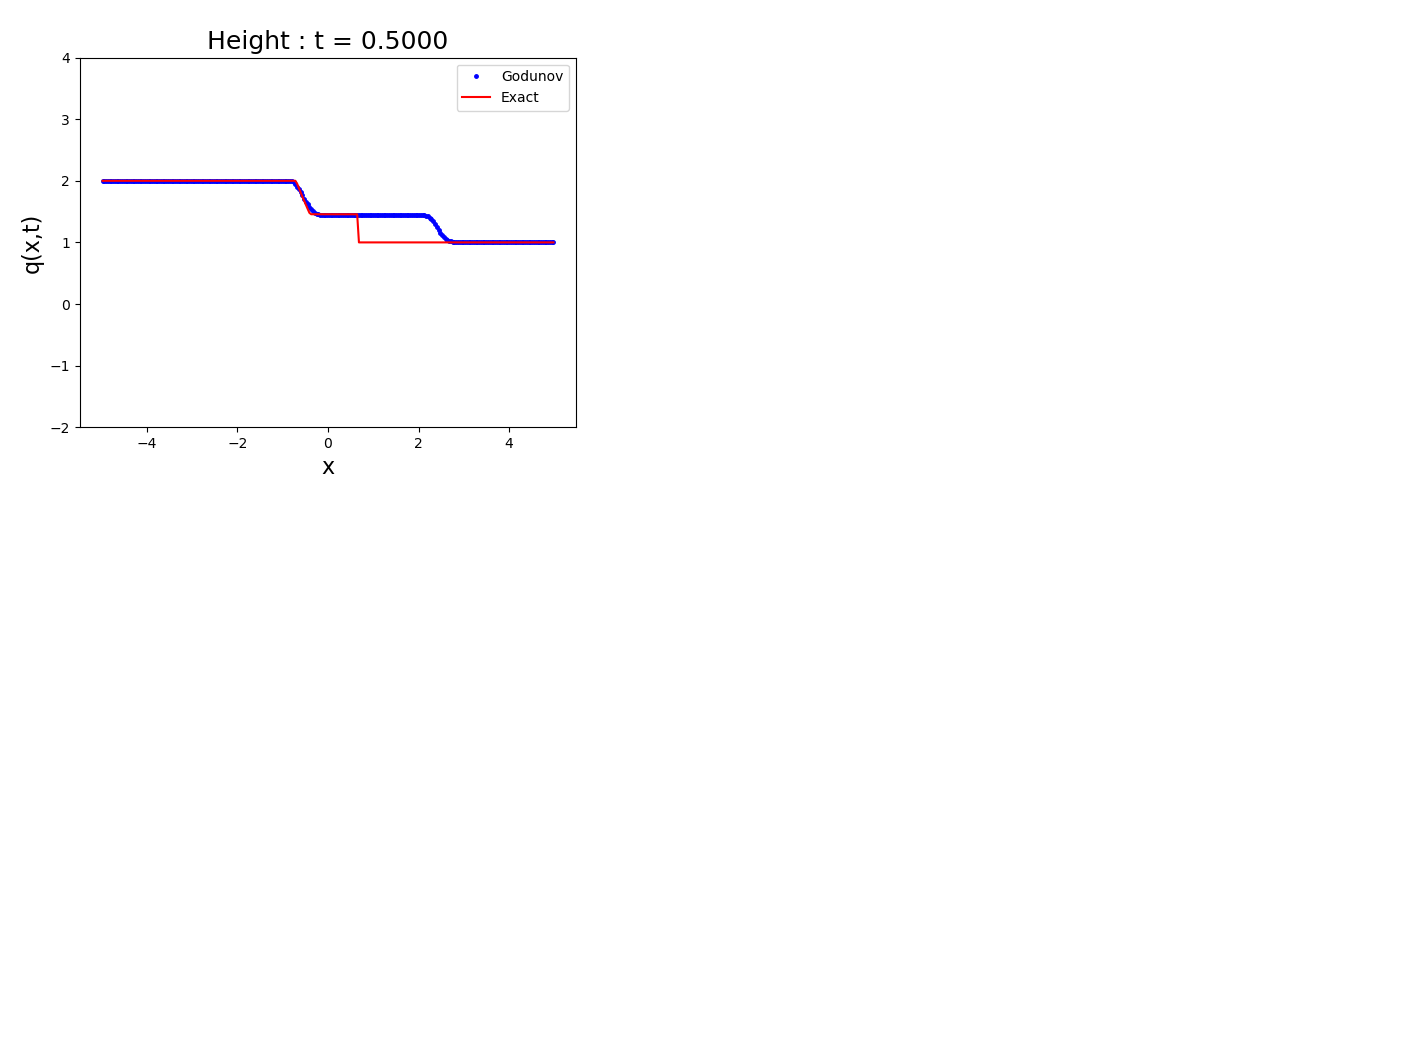

In [11]:
fig = figure(1)

clf()
# mq = 0 : Height field
# mq = 1 : Momentum field

mq = 0

if mq == 0:
    tstr = 'Height : t = {:.4f}'

    hdl, = plot(x,qold1,'b.',markersize=5,label='Godunov')
    
else:
    tstr = 'Momentum : t = {:.4f}'
    hdl, = plot(x,qold2,'b.',markersize=5,label='Godunov')
    
htitle = title(tstr.format(0),fontsize=18)

q0 = qexact(x,to,mq,ql,qr,g)

hde, = plot(x,q0,'r-',markersize=5,label='Exact')

#Time loop
time = 0
dt = dt_int

for n in range(M):
    #exact solver
    q = qexact(x,t[n],mq,ql,qr,g)
    
    hde.set_ydata(q)
    
    smax = 0
    for i in range(N):
        if i == N-1:
            q1l = array([qold1[i],qold2[i]])
            q1r = array([qold1[i],qold2[i]])
        else:
            q1l = array([qold1[i],qold2[i]])
            q1r = array([qold1[i+1],qold2[i+1]])
        
        hms = exact(q1l,q1r,0,0,g)
        hums = exact(q1l,q1r,0,1,g)
        u = hums/hms
        q1e = array([hms,hums])
        
        f1 = flux(q1e) #f_{i+1/2}
        
        #speeds
        s1 = speed(hms,u,g)[1]
        s1l = speed(q1l[0],q1l[1]/q1l[0],g)[0]
        s1r = speed(q1r[0],q1r[1]/q1r[0],g)[1]
        
        smax = max(array([smax,abs(s1l),abs(s1r)]))
        if i == 0:
            q2l = array([qold1[i],qold2[i]])
            q2r = array([qold1[i],qold2[i]])
        else:
            q2l = array([qold1[i-1],qold2[i-1]])
            q2r = array([qold1[i],qold2[i]])
        
        h2ms = exact(q2l,q2r,0,0,g)
        h2ums = exact(q2l,q2r,0,1,g)
        u2 = h2ums/h2ms
        
        q2e = array([h2ms,h2ums])
        f2 = flux(q2e) #f_{i-1/2}
        
        #speeds
        s2 = speed(h2ms,u2,g)[1]
        s2l = speed(q2l[0],q2l[1]/q2l[0],g)[0]
        s2r = speed(q2r[0],q2r[1]/q2r[0],g)[1]
        
        smax = max(array([smax,abs(s2l),abs(s2r)]))
        
        #soln at N+1
        qnew1[i] = qold1[i] - (dt/dx)*(f1[0] - f2[0])

        qnew2[i] = qold2[i] - (dt/dx)*(f1[1] - f2[1])

    #max_speed 
    cfl_max = smax*dt_old/dx
    
    dt = dt_old*cfl/cfl_max
    #print(smax)
    if mq == 0:
        hdl.set_ydata(qnew1)
    else:
        hdl.set_ydata(qnew2)
        
    #overwrite the soln
    qold1 = qnew1
    qold2 = qnew2
    
    #update time step
    time = time + dt
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t[n]))
    
    ylim([ay,by])
    legend()
    pause(0.1)

    fig.canvas.draw()        

    